In [1]:
!pip install opencv_contrib_python==3.4.2.17 --force-reinstall

  Using cached opencv_contrib_python-3.4.2.17-cp37-cp37m-manylinux1_x86_64.whl (30.6 MB)
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 3.4.2.17
    Uninstalling opencv-contrib-python-3.4.2.17:
      Successfully uninstalled opencv-contrib-python-3.4.2.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 whic

In [194]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow

# Verify OpenCV version
print(cv.__version__)

3.4.2


# Caricamento immagini 

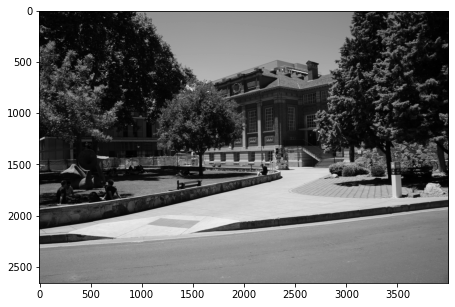

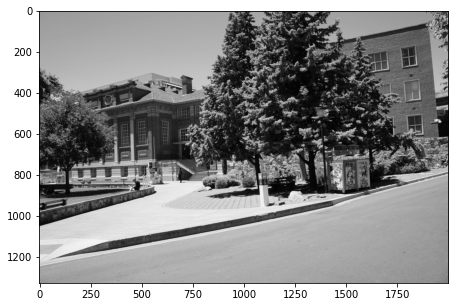

In [209]:
# Image loading
plt.rcParams['figure.figsize'] = [15, 5] # width, height
im1 = cv.imread('images/DSC02930.jpg',0)
im2 = cv.imread('images/DSC02931.jpg',0)
plt.imshow(im1, cmap='gray'); plt.show()
plt.imshow(im2, cmap='gray'); plt.show()

# Stitching point delle immagini e matching 

In [210]:
# Keypoints extraction
sift = cv.xfeatures2d.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)
# Features matching
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

In [211]:
len(kps1)

81981

In [212]:
len(kps2)

18122

# Omografia della trasformazione dal secondo set al primo

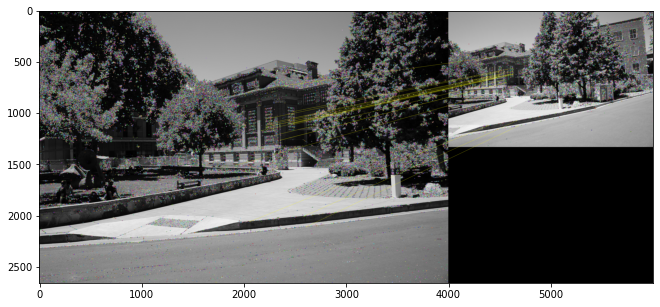

In [213]:
# Visualization of only filtered matches
matches = sorted(matches, key=lambda x:x.distance)
result = cv.drawMatches(im1, kps1, im2, kps2, matches[0:20], None, matchColor=[255,255,0])
plt.imshow(result); plt.show()

In [214]:
def myHomography(kps1, kps2, matches):
  matches = matches[0:10]
  matrix, mask =  cv.findHomography(np.float32([kps1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2), np.float32([kps2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2), cv.RANSAC,5.0)
  return matrix

In [215]:
H = myHomography(kps1, kps2, matches)

In [216]:
H

array([[ 1.08427383e+00, -5.88542743e-03, -1.54789684e+03],
       [ 1.99941208e-01,  9.14271402e-01, -3.80897428e+02],
       [ 3.15590445e-04,  2.86208764e-05,  1.00000000e+00]])

# Applico l'omografia alla seconda immagine

In [217]:
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]
  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)
  list_of_points_2 = cv.perspectiveTransform(temp_points, H)
  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)
  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  translation_dist = [-x_min,-y_min]
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
  output_img = cv.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1
  return output_img

In [218]:
result = warpImages(im2, im1, H)

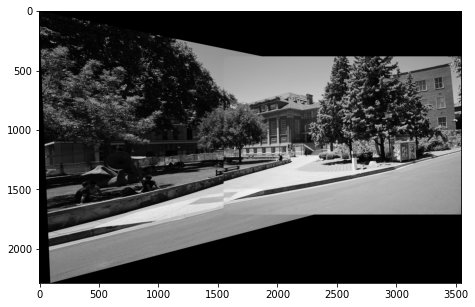

In [219]:
plt.imshow(result, cmap='gray'); plt.show()